In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explanations of machine learning models using CAM-based methods

In this tutorial you are going to examine how to use the CAM-based explanations to evaluate your ML model.

We begin by introducing the fundamental blocks used to perform an explanation on a single image:

This example corresponds to the one from the official tutorial and is used for demonstration purposes

In [103]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import torchmetrics
import numpy as np
import pandas as pd
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import matplotlib.pyplot as plt

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255

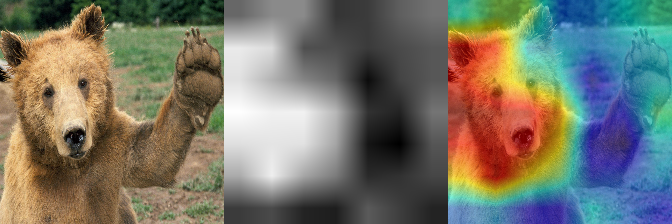

In [104]:
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

## Things to note down:

- You can change the model (any model from torchvision.models is typically fine)
- You can change the target layer (i.e. the layer which generates the predictions), but it recommended that you use the final convolutional layer 
- If you do not specify the target class, then the explainer is going to select the most likely class (i.e. the class with the highest prediction confidence)

The confidence increase percent: 0.010518636554479599
The visualization of the pertubated image for the metric:


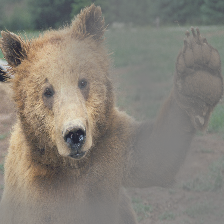

In [105]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Benchmarking CAMs

You can use the existing benchmark method in your implementation if you wish, but it is here purely as an example of how to use different CAM attribution methods

100%|████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.61it/s]


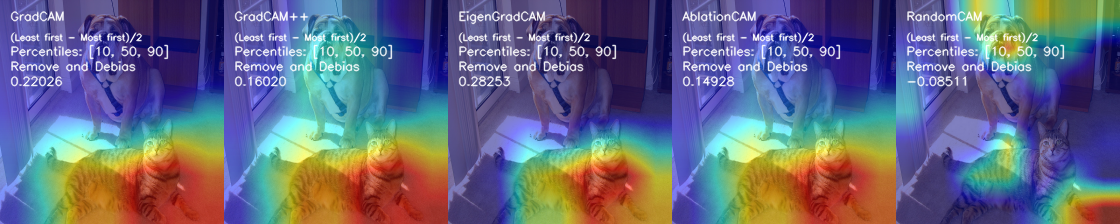

In [106]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(input_tensor, target_layers, img, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, use_cuda=True))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(img, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, cat_and_dog, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

## This section shows you how to load the MedMNIST dataset

In [107]:
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data; you are free to choose the dataset yourself, but beware that not all of 
# them are compatible with the standard torchvision models
data_flag = 'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
train_set, valid_set = random_split(train_set, [0.8, 0.2])
# You are expected to create the appropriate dataloaders to be used for training, testing and validation 
# We propose a 70-15-15 split, but this is entirely up to you

### YOUR CODE BELOW ###
med_model = models.resnet50(pretrained=True)
med_model.fc = nn.Linear(2048, 8)
BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/icb/mostafa.shahhosseini/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/icb/mostafa.shahhosseini/.medmnist/bloodmnist.npz


### Model training

Now that you have loaded the model and the dataset, you can proceed to training it
We provide you with a sample training loop, you are allowed to modify it as you please

Your goal here is to add the explanations to either the validation or the testing loop 
It is entirely up to you how to achieve this; the main goal of the exercise is to observe how 
the explanations change over the course of training.

Hint: you may want to run the explainer on the untrained model to get a baseline 'random' prediction

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchmetrics.functional as f

# You are expected to save the models during training 
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###
saved_models = None

def train(device='cuda', 
          model=None, 
          train_loader=None, 
          epochs=10, 
          learning_rate=0.001, 
          input_tensor=None, 
          targets=None, 
          image=None):
    images = []
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()
    metrics = {
        "auroc":[],
        "acc":[],
        "mce":[],
        "dice":[],
        "f1":[],
        "perc":[],
        "rec":[],
        "spec":[]
    }
    loss_total = []
    for epoch in tqdm(range(epochs)):
        predictions = []
        truth_labels = []
        losses = []
        valid_losses = []
        accuracies = []
        for i, (data, target) in enumerate(tqdm(train_loader)): 
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)
            loss.backward()
            optimizer.step()
            predictions += [output.cpu()]
            truth_labels += [np.array(labels)]
        predictions = torch.cat(predictions)
        truth_labels = torch.tensor(np.concatenate(np.array(truth_labels)))
        metr = calculate_metrics(predictions, truth_labels.flatten())
        for key in metrics:
            metrics[key] += [metr[key]]
        loss_total += [np.mean(losses)]
        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader)): 
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target)
                valid_losses.append(loss.item())

        # We suggest you modify this code to run the continuous explanations
        print(f"Grad-cam testing")
        target_layers = [model.layer4]
        with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
        images += [cam_image]
        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )
    metrics.update({'loss':loss_total})
    return model, images, metrics 

In [133]:
def test(device, model, data_loader, mean=0.5432, std=0.2731, input_tensor=None, targets=None, img=None):
    model.eval()
    preds = []
    pred_list = []
    # The target for the CAM is the Bear category.
    # As usual for classication, the target is the logit output
    # before softmax, for that category.
    # targets = [ClassifierOutputTarget(295)]
    target_layers = [model.layer4]
    correct=0
    with torch.no_grad():
        for index, (image, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            image = image.to(device)
            target = target

            output = model(image).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    print(f"Grad-cam testing")
    target_layers = [model.layer4]
    with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    return np.concatenate(pred_list), cam_image

In [110]:
def calculate_metrics(preds, targets):
    auroc = f.auroc(preds, targets.flatten(), task='multiclass', num_classes=8)
    acc = f.classification.accuracy(torch.argmax(preds, dim=1).flatten(), targets.flatten(), average='macro', task='multiclass', num_classes=8)
    mce = f.classification.multiclass_calibration_error(preds, targets, n_bins=2, norm='l2', num_classes=8)
    dice = f.dice(preds, targets, average='macro',  num_classes=8)
    f1 = f.f1_score(preds, targets, task="multiclass", num_classes=8)
    perc = f.precision(preds, targets, task="multiclass", average='macro', num_classes=8)
    rec = f.recall(preds, targets, task="multiclass", average='macro', num_classes=8)
    spec = f.specificity(preds, targets, task="multiclass", average='macro', num_classes=8)
    return dict(
                auroc=auroc,
                acc=acc,
                mce=mce,
                dice=dice,
                f1=f1,
                perc=perc,
                rec=rec,
                spec=spec)

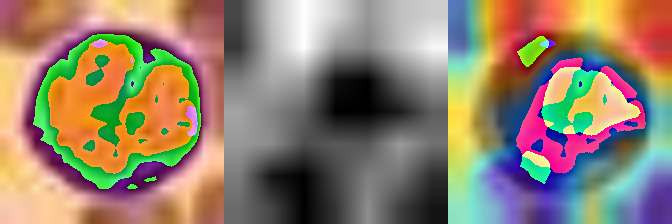

In [112]:
batch = list(iter(train_loader))[0]
batch_image, batch_targets = batch
image = batch_image[0]
target = batch_targets[0]
image = image.permute(2, 1, 0).numpy()
targets = [ClassifierOutputTarget(target)]
image = cv2.resize(image, (224, 224))
# image = np.float32(image) / 255 # THIS IS NOT REQUIRED FOR MEDMNIST

input_tensor = preprocess_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
# targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model.to('cuda:0'), target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.cuda(), targets=targets)
    cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*image), cam , cam_image))
Image.fromarray(images)

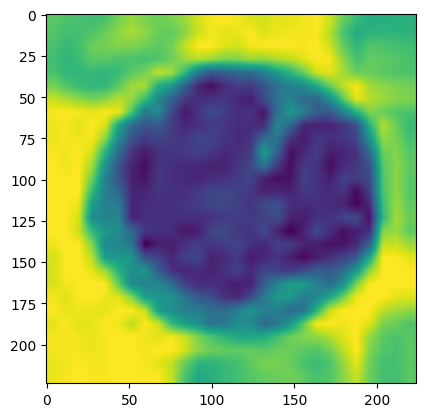

In [113]:
plt.imshow(input_tensor[0, 0, ...].numpy())

In [115]:
model, images, metrics = train('cuda', med_model, train_loader, 20, 0.001, input_tensor, targets, image)

100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.56it/s]

  5%|███▋                                                                     | 1/20 [00:07<02:19,  7.35s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 1 Loss: 0.530125 Validation loss: 0.303292 Acc: 82.295139 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:08<00:00,  9.10it/s]

 10%|███████▎                                                                 | 2/20 [00:16<02:29,  8.30s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 2 Loss: 307.318262 Validation loss: 2.009651 Acc: 20.416667 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 12.69it/s]

 15%|██████████▉                                                              | 3/20 [00:22<02:06,  7.47s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 3 Loss: 1.997966 Validation loss: 1.752025 Acc: 19.513889 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.82it/s]

 20%|██████████████▌                                                          | 4/20 [00:30<02:00,  7.52s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 4 Loss: 1.946295 Validation loss: 1.995919 Acc: 22.791667 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.92it/s]

 25%|██████████████████▎                                                      | 5/20 [00:37<01:52,  7.53s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 5 Loss: 1.762151 Validation loss: 1.321673 Acc: 30.350694 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 13.07it/s]

 30%|█████████████████████▉                                                   | 6/20 [00:44<01:39,  7.13s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 6 Loss: 1.195693 Validation loss: 0.863451 Acc: 54.638889 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.59it/s]

 35%|█████████████████████████▌                                               | 7/20 [00:50<01:26,  6.68s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 7 Loss: 0.746617 Validation loss: 0.597873 Acc: 71.944444 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.31it/s]

 40%|█████████████████████████████▏                                           | 8/20 [00:55<01:17,  6.44s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 8 Loss: 0.568446 Validation loss: 0.542929 Acc: 78.656250 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.36it/s]

 45%|████████████████████████████████▊                                        | 9/20 [01:04<01:16,  6.96s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 9 Loss: 0.462382 Validation loss: 0.569225 Acc: 82.545139 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00,  9.66it/s]

 50%|████████████████████████████████████                                    | 10/20 [01:12<01:14,  7.42s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 10 Loss: 0.423018 Validation loss: 0.475863 Acc: 84.361111 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 12.97it/s]

 55%|███████████████████████████████████████▌                                | 11/20 [01:19<01:04,  7.13s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 11 Loss: 0.369421 Validation loss: 0.449919 Acc: 86.475694 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.07it/s]

 60%|███████████████████████████████████████████▏                            | 12/20 [01:27<00:59,  7.42s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 12 Loss: 0.349842 Validation loss: 0.358305 Acc: 87.361111 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.82it/s]

 65%|██████████████████████████████████████████████▊                         | 13/20 [01:34<00:52,  7.47s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 13 Loss: 0.311599 Validation loss: 0.444906 Acc: 88.746528 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.07it/s]

 70%|██████████████████████████████████████████████████▍                     | 14/20 [01:42<00:44,  7.46s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 14 Loss: 0.296736 Validation loss: 0.389865 Acc: 89.111111 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.18it/s]

 75%|██████████████████████████████████████████████████████                  | 15/20 [01:50<00:38,  7.68s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 15 Loss: 0.273413 Validation loss: 0.310212 Acc: 90.055556 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00,  9.69it/s]

 80%|█████████████████████████████████████████████████████████▌              | 16/20 [01:58<00:31,  7.90s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 16 Loss: 0.310087 Validation loss: 0.314591 Acc: 89.076389 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.16it/s]

 85%|█████████████████████████████████████████████████████████████▏          | 17/20 [02:06<00:23,  7.75s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 17 Loss: 0.241887 Validation loss: 0.377567 Acc: 91.329861 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00,  9.86it/s]

 90%|████████████████████████████████████████████████████████████████▊       | 18/20 [02:14<00:15,  7.91s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 18 Loss: 0.213359 Validation loss: 0.272685 Acc: 92.281250 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.10it/s]

 95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [02:21<00:07,  7.76s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 19 Loss: 0.193952 Validation loss: 0.334899 Acc: 93.034722 



100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.00it/s]

100%|████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.47s/it]

Grad-cam testing
torch.Size([1, 3, 224, 224])
(224, 224, 3)
Train Epoch: 20 Loss: 0.204633 Validation loss: 0.269022 Acc: 92.809028 


<AxesSubplot: title={'center': 'Metrics'}>

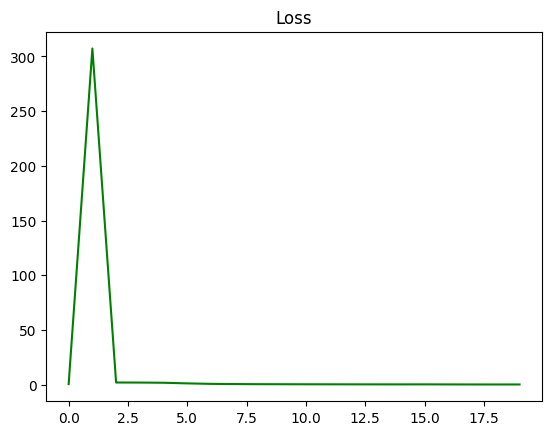

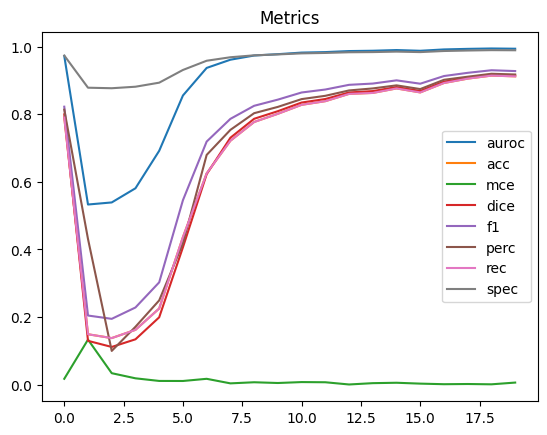

In [116]:
metric = pd.DataFrame.from_dict(metrics, orient = 'index', dtype='float32').T
loss = metric['loss']
metric = metric.drop(columns=['loss'])
loss.plot(title='Loss', color='green')
metric.plot(title='Metrics')

In [117]:
cam_imgs_1 = np.hstack(images[:5])
cam_imgs_2 = np.hstack(images[5:10])
cam_imgs_3 = np.hstack(images[10:15])
cam_imgs_4 = np.hstack(images[15:])

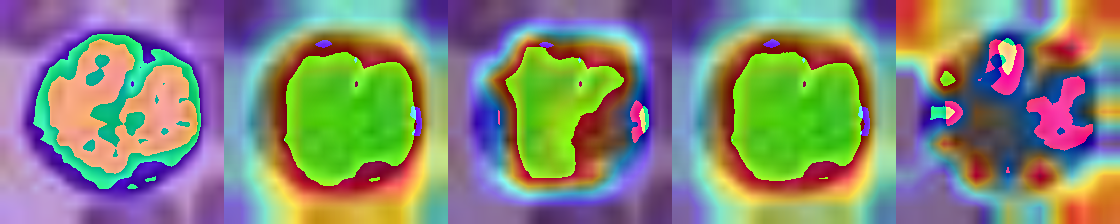

In [118]:
Image.fromarray(cam_imgs_1)

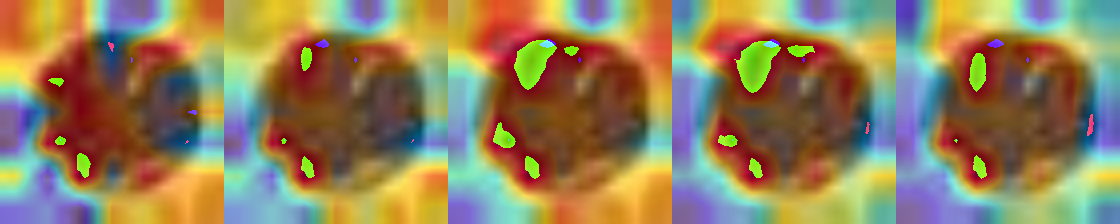

In [119]:
Image.fromarray(cam_imgs_2)

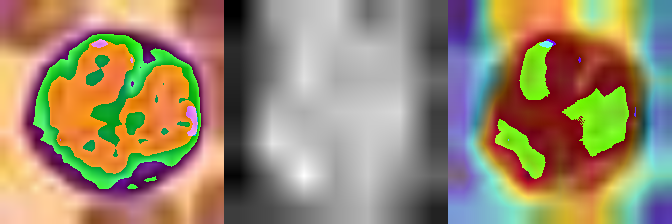

In [121]:
test_batch = list(iter(test_loader))[0]
test_batch_image, test_batch_targets = batch
test_image = test_batch_image[0]
test_target = test_batch_targets[0]
test_image = test_image.permute(2, 1, 0).numpy()
test_targets = [ClassifierOutputTarget(test_target)]
test_image = cv2.resize(test_image, (224, 224))
# test_image = np.float32(test_image) / 255

test_input_tensor = preprocess_image(test_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
# targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model.to('cuda:0'), target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=test_input_tensor.cuda(), targets=test_targets)
    cam_image = show_cam_on_image(test_image, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
test_images = np.hstack((np.uint8(255*image), cam , cam_image))
Image.fromarray(test_images)

In [134]:
pred, images = test('cuda', model, test_loader, input_tensor=test_input_tensor, targets=test_targets, img=test_image)


Test-loop: 100%|█████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 14.86it/s]


Test Accuracy: 91.347559
Grad-cam testing


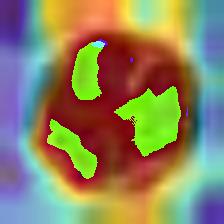

In [135]:
Image.fromarray(images)

100%|████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 39.38it/s]


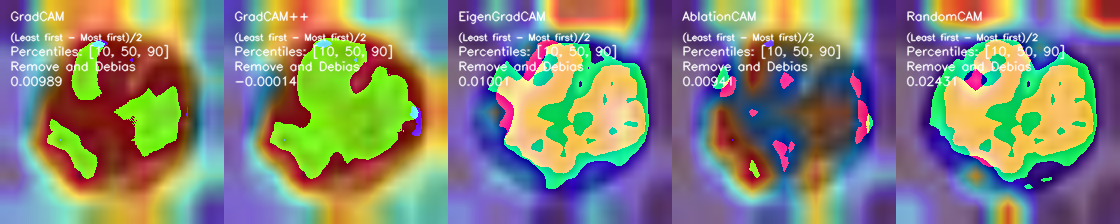

In [136]:
benchmark(input_tensor.cuda(), [model.layer4], image, eigen_smooth=False, aug_smooth=False, category=target)